In [1]:
from torchtext import data, datasets

# Define the fields associated with the sequences.
WORD = data.Field()
UD_TAG = data.Field()

# Download and the load default data.
train, val, test = datasets.UDPOS.splits(
    fields=(('word', WORD), ('udtag', UD_TAG), (None, None)))

print(vars(train[0]))

{'word': ['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.'], 'udtag': ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']}


In [2]:
# build vocaburary
WORD.build_vocab(train)
UD_TAG.build_vocab(train)

word_vocab = WORD.vocab
tag_vocab = UD_TAG.vocab

In [3]:
BATCH_SIZE = 64
train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), 
                                                  batch_size=BATCH_SIZE,
                                                  sort_key=lambda x: len(x.word),
                                                  shuffle=True,
                                                  repeat=False,
                                                  device="cuda:0")

In [5]:
from model import BiLSTM_CRF

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import random
import csv
import copy
import numpy as np
torch.manual_seed(1)

In [7]:
CUDA = True if torch.cuda.is_available() else False

In [17]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 128

bilstm_crf = BiLSTM_CRF(len(word_vocab.stoi), tag_vocab.stoi, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE)
if CUDA: 
    bilstm_crf=bilstm_crf.cuda()

optimizer = optim.RMSprop(bilstm_crf.parameters())

In [18]:
print(bilstm_crf)

BiLSTM_CRF(
  (word_embeds): Embedding(19676, 100, padding_idx=1)
  (lstm): LSTM(100, 64, bidirectional=True)
  (emissons): Linear(in_features=128, out_features=21, bias=True)
  (crf): CRF(num_tags=21)
)


In [19]:
batch = next(iter(train_iter))
bilstm_crf(batch.word, batch.udtag)

tensor(3716.0413, device='cuda:0', grad_fn=<NegBackward>)

In [20]:
def train(model, sents, labels):
    model.train()
    optimizer.zero_grad()
    loss = model(sents, labels)
    loss.backward()
    optimizer.step()
    return loss.item() / sents.size(1)

def test(model, sents, labels):
    model.eval()
    with torch.no_grad():
        loss = model(sents, labels)
    return loss.item() / sents.size(1)

In [22]:
EPOCHS = 20

total_train_loss = []
total_valid_loss = []

for epoch in range(EPOCHS):
    train_loss = []
    valid_loss = []
    
    print("epoch {} / {}".format(epoch, EPOCHS))
    
    for i, train_data in enumerate(train_iter):
        
        sents = train_data.word
        tags = train_data.udtag
                
        _tr_loss = train(bilstm_crf, sents, tags)
        _vl_loss = test(bilstm_crf, sents, tags)
        
        train_loss.append(_tr_loss)
        valid_loss.append(_vl_loss)
    
    total_train_loss.append(np.mean(train_loss))
    total_valid_loss.append(np.mean(valid_loss))
    
    print('train loss:{:.5f}, valid loss:{:.5f}'.format(total_train_loss[epoch],
                                                        total_valid_loss[epoch]))
    

epoch 0 / 20
train loss:6.89156, valid loss:2.78977
epoch 1 / 20
train loss:2.36055, valid loss:0.55015
epoch 2 / 20
train loss:1.20889, valid loss:0.22919
epoch 3 / 20
train loss:0.73698, valid loss:0.11103
epoch 4 / 20
train loss:0.51186, valid loss:0.06294
epoch 5 / 20
train loss:0.36597, valid loss:0.04162
epoch 6 / 20
train loss:0.28647, valid loss:0.03127
epoch 7 / 20
train loss:0.25647, valid loss:0.02356
epoch 8 / 20
train loss:0.22680, valid loss:0.02121
epoch 9 / 20
train loss:0.16895, valid loss:0.01480
epoch 10 / 20
train loss:0.16751, valid loss:0.01667
epoch 11 / 20
train loss:0.17909, valid loss:0.01335
epoch 12 / 20
train loss:0.16037, valid loss:0.01119
epoch 13 / 20
train loss:0.14980, valid loss:0.01219
epoch 14 / 20
train loss:0.12822, valid loss:0.00958
epoch 15 / 20
train loss:0.12843, valid loss:0.00793
epoch 16 / 20
train loss:0.13237, valid loss:0.00834
epoch 17 / 20
train loss:0.13965, valid loss:0.01125
epoch 18 / 20
train loss:0.12648, valid loss:0.00833
epo

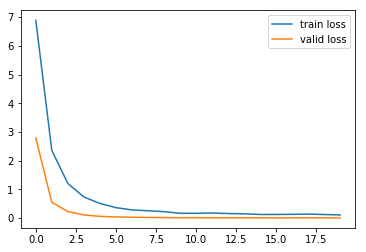

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(EPOCHS), total_train_loss, label="train loss")
plt.plot(range(EPOCHS), total_valid_loss, label="valid loss")
plt.legend()
plt.show()